In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-03_2021-08-03-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,88755,None,None,61311.445816
2020-06-13,88756,None,None,58146.785767
2020-06-14,88757,None,None,55048.449683
2020-06-15,88758,None,None,52289.195603
2020-06-16,88759,None,None,49818.470600
...,...,...,...,...
2021-07-30,89168,None,None,799196.549044
2021-07-31,89169,None,None,794291.645232
2021-08-01,89170,None,None,785910.630700


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-08-02_2021-08-02-18-02.pickle


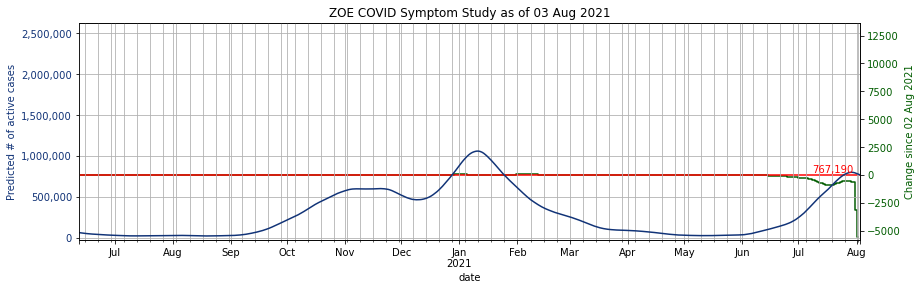

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

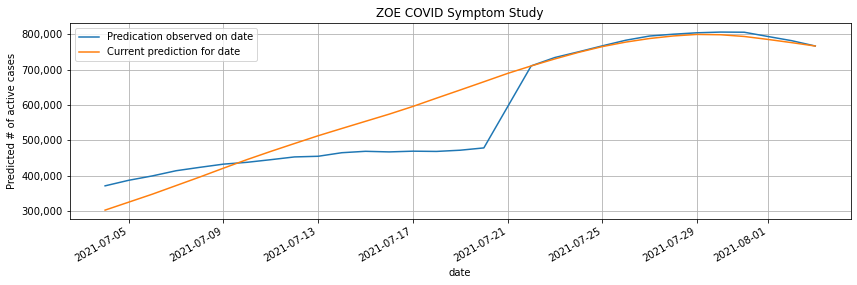

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Tue 03 Aug 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
186,Lincoln,E07000138,10.300191
246,Rotherham,E08000018,3.776554
101,Erewash,E07000036,3.312765
347,Hammersmith and Fulham,E09000013,3.197241
115,Hastings,E07000062,2.905318
380,Waltham Forest,E09000031,2.904238
165,Chorley,E07000118,2.849595
247,Sheffield,E08000019,2.789834
2,Redcar and Cleveland,E06000003,2.656052
140,Melton,E07000133,2.620624
